# Libraries

In [0]:
#library to calculate distance between two points on earth knowing the coordinates
%pip install haversine
%restart_python


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import haversine as hvs

reference_date = pd.to_datetime("2023-08-01 00:00:00")

In [0]:
df_spark = spark.table("workspace.default.sessions_filtered_spark")
df = df_spark.toPandas()

In [0]:
#"DEACTIVATED" TO MAKE THE NOTEBOOK LIGHTER
#df_spark = spark.table("workspace.default.sessions_spark")
#df_UNFILTEREDsessions = df_spark.toPandas()

In [0]:
#"DEACTIVATED" TO MAKE THE NOTEBOOK LIGHTER
#df_spark = spark.table("workspace.default.hotels_spark")
#df_UNFILTEREDhotels = df_spark.toPandas()

#SUMMARY

---
**NIGHTS**
* PROBLEM 1: wrong numbers when compared to check in and out time
  * REASON: they calculated first the check in and out datetime difference in hours and rounded using np.ceil(hours) (so that 23.1 -> 24), then they calculated the number of nights by dividing hours/24 and rounded using np.floor(nights) (so that 1.9 -> 1)
  * SOLUTION: calculate difference between check in and out dates, ignoring the time
* PROBLEM 2: late night check-in: Some check-in have taken place after midnight. Ignoring the time and using only date difference may be misleading in such cases.
  * SOLUTION: I will adjust the night calculation (adding +1) for those trips which check-in happened betweem midnight and 6
* PROBLEM 3: Negative (or sometimes zero) nights
  * REASON: check-in datetime >= check-out datetime, for no understandable reason
  * SOLUTION: I need a way to adjust the check in or out dates (time is impossible to fix, let's fix at least the dates). I noticed that flight dates (departure and return times) are very reliable:
    1. Departure date is always max 1 day before the check-in
    2. Return date is always max 3 days after the check-out
  
    Given these considerations, I adjusted the check-out date, using the return flight date, only for those trips for which:
    * departure flight takes place the same day as the check in
    * return flight takes place the day after the departure (when return is later, we cannot derive the check-out date because of point 2 above)
    * all others were dropped (~131)

CONSIDERATIONS:

* We have "nights_calc" for all those "booked_and_travelled" sessions where hotel was booked

---
**TRIP_ID**

There are 599 Trip_ID that appear twice. One is booking, the other is cancellation of the previous booking.

Something inexplicable: check-in time for these trips (???).

In the overall dataset, there are 606 cancellations. 599 belong to the double-Trip_ID group. The remaining 7 are cancellations of trips booked before 2023 (remember that we filtered the original database to have only sessions that happened > 2023). I will drop these 7 rows, since it makes no sense to have them.

Understanding about it
* Sessions **with a trip_id** and **without cancellation** correspond to **booked trips**
* Sessions **with a trip_id** and **with cancellation** are sessions where booked **trips are cancelled**
* Sessions **without trip_id** correspond to **unbooked trip**

I will create a new column regarding the session status with either one of the following values:
* **booked_and_travelled** (Sessions where a booking is made and the trip is eventually taken)
* **booked_but_cancelled** (Sessions where a booking is made, but that trip is canceled in a later session)
* **cancellation_session** (Sessions whose main action is canceling a previously booked trip)
* **no_booking** (Sessions that end without any booking)

---
**DISTANCES**

* Every session has a home_airport and respective coordinates (no missing value in the whole df)
* Destination airport coordinates are missing ONLY when the flight wasn't booked, or in cancellation sessions
* 2332 (out of 15366) trips (booked_and_travelled) have no destination airport coordinates, because no flight was booked
* 50 (out of 599) trips (booked_but_cancelled) have no destination airport coordinates, because no flight was booked

I calculated the distances between airports wherever possible

---
**DURATION**

Goal: estimate trip duration

Consideration:
* when return flight is booked, we have nr of days between flights
* when hotel is booked, we have nr of nights (also for booked_but_cancelled, which makes no sense, since the trip never happened)
* 16 (out of 15366) trips (booked_and_travelled) have no return and hotel booked, and therefore no nr of nights or days between flights
* 8 (out of 599) trips (booked_but_cancelled) have no return and hotel booked, and therefore no nr of nights or days between flights

Some trip has no hotel booked (i.e. no nr of nights), some other has no flight booked (no days between flights).
We should consider both to estimate the trip duration:
* those sessions with both data, we take the highest one (usually days between flights)
* otherwise, we use the only one that appears in the table

---
**BASEFARE**

Which session has basefare not null:
* all and only those trips with both departure and return flights booked
* 13034 sessions "booked and travelled" (all "booked and travelled" sessions with flight_booked == True)
* 549 sessions "booked but cancelled"
* the 549 cancellation sessions of previous point
---
**ROOM PRICE**
* We have room price for all "booked and travelled" trip where hotel was booked
* No room price for all "booked and travelled" trip where hotel was not booked

# Check & Adjustments

## Missing values and Duplicates

In [0]:
df.shape

(49211, 41)

In [0]:
# information about the table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49211 entries, 0 to 49210
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   session_id                      49211 non-null  object        
 1   user_id                         49211 non-null  int64         
 2   trip_id                         16702 non-null  object        
 3   session_start                   49211 non-null  datetime64[ns]
 4   session_end                     49211 non-null  datetime64[ns]
 5   page_clicks                     49211 non-null  int64         
 6   flight_discount                 49211 non-null  bool          
 7   flight_discount_amount          8282 non-null   float64       
 8   hotel_discount                  49211 non-null  bool          
 9   hotel_discount_amount           6205 non-null   float64       
 10  flight_booked                   49211 non-null  bool          
 11  ho

In [0]:
#searching for null values
a = round(df.isnull().sum()/df.shape[0]*100,1)
a[a>0]

trip_id                           66.1
flight_discount_amount            83.2
hotel_discount_amount             87.4
origin_airport                    71.0
destination                       71.0
destination_airport               71.0
seats                             71.0
return_flight_booked              71.0
departure_time                    71.0
return_time                       72.3
checked_bags                      71.0
trip_airline                      71.0
destination_airport_lat           71.0
destination_airport_lon           71.0
base_fare_usd                     71.0
hotel_name                        70.1
nights                            70.1
rooms                             70.1
check_in_time                     70.1
check_out_time                    70.1
hotel_price_per_room_night_usd    70.1
dtype: float64

In [0]:
#checking for duplicates values
df.duplicated().sum()

np.int64(0)

## Some Feature Engineering

In [0]:
df['age_in_2023'] = 2023 - df['birthdate'].dt.year  # Session dates go from january 2023 to end of july 2023, so it makes sense to use 2023 as reference year to calculate age


df['session_duration_min'] = (df['session_end']-df['session_start']).dt.total_seconds()/60
#df['booking_window_days'] = (df['departure_time']-df['session_start']).dt.days
#this last one must be checked because they might have start a session but not departed yet (look at df.info(), there are so many missing value for departure_time)

delta = df['return_time'].dt.date - df['departure_time'].dt.date
df['days_between_flights'] = delta.apply(lambda x: x.days if pd.notnull(x) else None)


# ---- AGE BINS ------------------------------------------------------------------------------------------------------
#df['age_bin'] = pd.cut(df.age_in_2023, bins=range(int(df['age_in_2023'].min()), int(df['age_in_2023'].max()) + 10, 10), right = False)  # OLD CODE TO CALCULATE AGE BINS (WHEN I WAS USING AGE_IN_2025)


bins_range = [df.age_in_2023.min(), 20, 30, 40, 50, 60, 70, 80, 90]
# min age is 17, max age is 88 -> I therefore created bins: from 17 to 20, then every 10 years 

df['age_bin'] = pd.cut(df.age_in_2023, bins=bins_range, right=False)

## Nights Problem (and general date check)

Something is weird with "nights" because they are not supposed to be negative (but there are negative nights)

Furthermore, we noticed that the difference between check-in and check-out times do not correspond to the number of nights properly, here I will try to understand why

In [0]:
#number of sessions with nights <=0
df.loc[df.nights <=0 ,"nights"].value_counts()

nights
 0.0    1228
-1.0     106
-2.0       1
Name: count, dtype: int64

In [0]:
#proportion of users with negative nights
df.loc[df.nights < 0, 'user_id'].nunique() / df['user_id'].nunique() *100

1.717239079693231

In [0]:
#proportion of users with zero nights
df.loc[df.nights == 0, 'user_id'].nunique() / df['user_id'].nunique() *100

18.10603534511504

In [0]:
df[df.cancellation==False]#[df.nights==0]

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
0,509635-08ddac6e534e4c32864b82b588bfc4c2,509635,509635-ce74796962f7482f94cdf4c1e4ea2f09,2023-07-20 15:28:00,2023-07-20 15:30:17,18,False,NaN,False,NaN,True,True,False,1986-12-13,M,True,False,usa,austin,AUS,30.194,-97.670,2023-01-04,AUS,new york,JFK,1.0,False,2023-07-29 07:00:00,NaT,0.0,Delta Air Lines,40.640,-73.779,198.27,Four Seasons - new york,1.0,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,154.0,37,2.283333,NaN,"[30, 40)"
1,581111-e14ccd371d6e47b6b53035273e2537db,581111,581111-1b8ef93f9b8243fc986d937547be6e10,2023-07-17 13:44:00,2023-07-17 13:46:19,19,True,0.10,False,NaN,True,True,False,1978-08-26,O,True,True,usa,las vegas,LSV,36.236,-115.034,2023-02-08,LSV,san diego,NZY,1.0,True,2023-07-22 14:00:00,2023-07-28 14:00:00,0.0,Ryanair,32.699,-117.215,77.00,Wyndham - san diego,4.0,1.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00,228.0,45,2.316667,6.0,"[40, 50)"
2,554269-341890533eec4585bf917de647933f76,554269,554269-396c10d3be7644d098b13800c63b3fba,2023-07-20 04:02:00,2023-07-20 04:04:54,24,False,NaN,False,NaN,True,True,False,1976-05-26,F,True,True,usa,san diego,SAN,32.733,-117.189,2023-01-26,SAN,toronto,YZD,1.0,True,2023-07-25 07:00:00,2023-07-30 07:00:00,1.0,American Airlines,43.862,-79.370,581.41,Wyndham - toronto,4.0,1.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,49.0,47,2.900000,5.0,"[40, 50)"
3,539221-634340361b1649f4b8d59d6d24b4d5e7,539221,539221-a72802fb2be44597afab005f30cf89d6,2023-07-18 17:52:00,2023-07-18 17:54:20,19,False,NaN,False,NaN,True,True,False,1970-06-26,F,True,True,usa,new york,JFK,40.640,-73.779,2023-01-19,JFK,chicago,MDW,1.0,True,2023-07-29 09:00:00,2023-07-31 09:00:00,1.0,Southwest Airlines,41.786,-87.752,213.44,Rosewood - chicago,1.0,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00,120.0,53,2.333333,2.0,"[50, 60)"
4,673286-14a80232e4904989bfa0e96dd6dd266e,673286,673286-46e617c1b27b4fbc8f0aed5ed1a146bd,2023-07-19 20:58:00,2023-07-19 20:59:12,10,False,NaN,False,NaN,False,True,False,1958-07-27,F,True,False,usa,los angeles,LAX,33.942,-118.408,2023-03-18,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,Starwood - houston,5.0,1.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00,194.0,65,1.200000,NaN,"[60, 70)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49206,607350-5bb5320a1c024c0f927fc592514dd3f0,607350,607350-27395ac73a98434f80e7bee52fae8481,2023-02-25 17:20:00,2023-02-25 17:21:24,11,False,NaN,False,NaN,True,False,False,1986-08-16,F,False,True,canada,victoria,YYJ,48.647,-123.426,2023-02-20,YYJ,san francisco,SFO,1.0,True,2023-03-08 16:00:00,2023-03-12 16:00:00,1.0,Alaska Airlines,37.619,-122.375,204.67,None,NaN,NaN,NaT,NaT,NaN,37,1.400000,4.0,"[30, 40)"
49207,557762-b8343bd89c3645dd98cf16573b5063dd,557762,557762-b31c36e8907748c082cfc601a3032b0f,2023-05-19 19:14:00,2023-05-19 19:18:37,37,True,0.15,False,NaN,True,False,False,1954-11-16,F,False,False,usa,san diego,NZY,32.699,-117.215,2023-01-28,NZY,los angeles,LSQ,1.0,True,2024-03-23 13:00:00,2024-04-04 13:00:00,0.0,United Airlines,33.942,-118.408,32.00,None,NaN,NaN,NaT,NaT,NaN,69,4.616667,12.0,"[60, 70)"
49208,557726-a9a3f71050e3450885740981557a7bb4,557726,557726-a0958b48c50e4f1c92c1ba5829a09ca7,2023-03-17 18:19:00,2023-03-17 18:21:55,23,False,NaN,True,0.15,True,False,False,1974-05-09,F,True,F

Let's first check if nights correspond to difference between check in and out

In [0]:
night_df = df[['hotel_booked', 'cancellation','nights', 'check_in_time', 'check_out_time']].dropna(subset=['check_in_time', 'check_out_time'])
night_df.head(5)
#looking at nights and check in and out times, something is wrong...

,hotel_booked,cancellation,nights,check_in_time,check_out_time
0,True,False,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00
1,True,False,4.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00
2,True,False,4.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00
3,True,False,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00
4,True,False,5.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00


I suppose that the number of nights were calculated as difference between check_in_time and check_out_difference. However, as can you see, it seems that they are not right (row 0, 1 night between 29/07 and 31/07, it makes no sense; it should be 2 nights). What it is wrong? maybe they calculated the number of nights as difference between timestamps, i.e. difference between hours too, and they counted 1 night only when the difference between dates was min 24h. In case it was below 24h, it did not count as 1 night. I have to verify this assumption

let's check how they rounded the difference between dates

In [0]:
#here we check if they used .round(0) to round the difference
nights_diff_round = ((night_df['check_out_time'] - night_df['check_in_time']).dt.total_seconds()/86400).map(lambda x: round(x,0))

In [0]:
#here I check if they used np.floor(x) to round the difference
nights_diff_floor = ((night_df['check_out_time'] - night_df['check_in_time']).dt.total_seconds()/86400).map(lambda x: np.floor(x))
#. np.floor(1.9 days) -> 1 day

In [0]:
#concat night_df with the difference calculated using np.floor(x)
night_df = pd.concat([night_df, nights_diff_floor], axis=1).rename(columns={0: 'nights_diff_floor'})
night_df.head(5)

,hotel_booked,cancellation,nights,check_in_time,check_out_time,nights_diff_floor
0,True,False,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,1.0
1,True,False,4.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00,4.0
2,True,False,4.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,4.0
3,True,False,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00,1.0
4,True,False,5.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00,5.0


In [0]:
#here I check those cells which difference between nights and nights_diff_floor is not zero
night_df[(night_df.nights - night_df.nights_diff_floor != 0) 
         & (night_df.check_in_time.dt.time > pd.to_datetime('11:00:00').time())]
#it seems that when the check-in hour is above 12:00, nights - nights_diff_floor is 0
#before 12:00, the difference is !=0 (try replacing 12:00 with 11:00)

,hotel_booked,cancellation,nights,check_in_time,check_out_time,nights_diff_floor
10,True,False,15.0,2023-07-25 11:38:00.015,2023-08-09 11:00:00,14.0
11,True,False,2.0,2023-07-25 11:27:17.775,2023-07-27 11:00:00,1.0
14,True,False,3.0,2023-07-31 11:21:48.285,2023-08-03 11:00:00,2.0
16,True,False,2.0,2023-07-29 11:14:57.570,2023-07-31 11:00:00,1.0
29,True,False,2.0,2023-07-27 11:52:40.395,2023-07-29 11:00:00,1.0
...,...,...,...,...,...,...
48865,True,True,7.0,2023-09-29 11:45:10.620,2023-10-06 11:00:00,6.0
48874,True,True,2.0,2023-02-16 11:30:10.890,2023-02-18 11:00:00,1.0
48882,True,True,1.0,2023-02-10 11:43:55.920,2023-02-11 11:00:00,0.0
48890,True,True,1.0,2023-01-23 11:25:39.810,2023-01-24 11:00:00,0.0


because of what I could see from the previous cell, it seems that when the difference between 2 consecutive days is < 23 hours, they rounded to 0 days. When it is between 23 and 24 hours, they counted as 1 day.

Possible reason: they calculated first the date difference in hours and rounded using np.ceil(hours) (so that 23.1 -> 24), then they calculated the number of nights by dividing hours/24 and rounded using np.floor(nights) (so that 1.9 -> 1)

In [0]:
# let's prove the possible reason explained above, by first creating a new nigh dataframe
night_df2 = df[['hotel_booked', 'cancellation', 'nights', 'check_in_time', 'check_out_time']].dropna(subset=['check_in_time', 'check_out_time']).reset_index(drop=True)

# here I create a series of differences between check out and check in time, according to my assumptions explained above
nights_diff_floor2 = ((((night_df2['check_out_time'] - night_df2['check_in_time']).dt.total_seconds()/3600).map(lambda x: np.ceil(x)))/24).map(lambda x: np.floor(x))
nights_diff_floor2

0         1.0
1         4.0
2         4.0
3         1.0
4         5.0
         ... 
14721     1.0
14722     3.0
14723     2.0
14724    11.0
14725     2.0
Length: 14726, dtype: float64

In [0]:
# I concatenate the new series with the night_df2
night_df2 = pd.concat([night_df2[night_df2.check_out_time.notna()], nights_diff_floor2], axis=1).rename(columns={0: 'nights_diff_floor'})
night_df2.head(5)

,hotel_booked,cancellation,nights,check_in_time,check_out_time,nights_diff_floor
0,True,False,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,1.0
1,True,False,4.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00,4.0
2,True,False,4.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,4.0
3,True,False,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00,1.0
4,True,False,5.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00,5.0


In [0]:
# I check if the difference between the nights column and the nights column calculated according to my assumption
night_df2[night_df2.nights - night_df2.nights_diff_floor != 0]
# it worked!

,hotel_booked,cancellation,nights,check_in_time,check_out_time,nights_diff_floor


CONCLUSION ON NIGHT CALCULATION PROBLEM:

As I demonstrated above, they calculated first the date difference in hours and rounded using np.ceil(hours) (so that 23.1 -> 24), then they calculated the number of nights by dividing hours/24 and rounded using np.floor(nights) (so that 1.9 -> 1)

I will replace the night values with values properly calculated as difference between check in and out dates.

In [0]:
df.head(5)

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
0,509635-08ddac6e534e4c32864b82b588bfc4c2,509635,509635-ce74796962f7482f94cdf4c1e4ea2f09,2023-07-20 15:28:00,2023-07-20 15:30:17,18,False,NaN,False,NaN,True,True,False,1986-12-13,M,True,False,usa,austin,AUS,30.194,-97.670,2023-01-04,AUS,new york,JFK,1.0,False,2023-07-29 07:00:00,NaT,0.0,Delta Air Lines,40.640,-73.779,198.27,Four Seasons - new york,1.0,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,154.0,37,2.283333,NaN,"[30, 40)"
1,581111-e14ccd371d6e47b6b53035273e2537db,581111,581111-1b8ef93f9b8243fc986d937547be6e10,2023-07-17 13:44:00,2023-07-17 13:46:19,19,True,0.1,False,NaN,True,True,False,1978-08-26,O,True,True,usa,las vegas,LSV,36.236,-115.034,2023-02-08,LSV,san diego,NZY,1.0,True,2023-07-22 14:00:00,2023-07-28 14:00:00,0.0,Ryanair,32.699,-117.215,77.00,Wyndham - san diego,4.0,1.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00,228.0,45,2.316667,6.0,"[40, 50)"
2,554269-341890533eec4585bf917de647933f76,554269,554269-396c10d3be7644d098b13800c63b3fba,2023-07-20 04:02:00,2023-07-20 04:04:54,24,False,NaN,False,NaN,True,True,False,1976-05-26,F,True,True,usa,san diego,SAN,32.733,-117.189,2023-01-26,SAN,toronto,YZD,1.0,True,2023-07-25 07:00:00,2023-07-30 07:00:00,1.0,American Airlines,43.862,-79.370,581.41,Wyndham - toronto,4.0,1.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,49.0,47,2.900000,5.0,"[40, 50)"
3,539221-634340361b1649f4b8d59d6d24b4d5e7,539221,539221-a72802fb2be44597afab005f30cf89d6,2023-07-18 17:52:00,2023-07-18 17:54:20,19,False,NaN,False,NaN,True,True,False,1970-06-26,F,True,True,usa,new york,JFK,40.640,-73.779,2023-01-19,JFK,chicago,MDW,1.0,True,2023-07-29 09:00:00,2023-07-31 09:00:00,1.0,Southwest Airlines,41.786,-87.752,213.44,Rosewood - chicago,1.0,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00,120.0,53,2.333333,2.0,"[50, 60)"
4,673286-14a80232e4904989bfa0e96dd6dd266e,673286,673286-46e617c1b27b4fbc8f0aed5ed1a146bd,2023-07-19 20:58:00,2023-07-19 20:59:12,10,False,NaN,False,NaN,False,True,False,1958-07-27,F,True,False,usa,los angeles,LAX,33.942,-118.408,2023-03-18,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,Starwood - houston,5.0,1.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00,194.0,65,1.200000,NaN,"[60, 70)"


In [0]:
if 'nights_calc' not in df.columns:
    df['nights'] = (df['check_out_time'].dt.date - df['check_in_time'].dt.date).apply(lambda x: x.days)
    df.rename(columns={'nights': 'nights_calc'}, inplace=True)
df.head(5)

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
0,509635-08ddac6e534e4c32864b82b588bfc4c2,509635,509635-ce74796962f7482f94cdf4c1e4ea2f09,2023-07-20 15:28:00,2023-07-20 15:30:17,18,False,NaN,False,NaN,True,True,False,1986-12-13,M,True,False,usa,austin,AUS,30.194,-97.670,2023-01-04,AUS,new york,JFK,1.0,False,2023-07-29 07:00:00,NaT,0.0,Delta Air Lines,40.640,-73.779,198.27,Four Seasons - new york,2.0,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,154.0,37,2.283333,NaN,"[30, 40)"
1,581111-e14ccd371d6e47b6b53035273e2537db,581111,581111-1b8ef93f9b8243fc986d937547be6e10,2023-07-17 13:44:00,2023-07-17 13:46:19,19,True,0.1,False,NaN,True,True,False,1978-08-26,O,True,True,usa,las vegas,LSV,36.236,-115.034,2023-02-08,LSV,san diego,NZY,1.0,True,2023-07-22 14:00:00,2023-07-28 14:00:00,0.0,Ryanair,32.699,-117.215,77.00,Wyndham - san diego,5.0,1.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00,228.0,45,2.316667,6.0,"[40, 50)"
2,554269-341890533eec4585bf917de647933f76,554269,554269-396c10d3be7644d098b13800c63b3fba,2023-07-20 04:02:00,2023-07-20 04:04:54,24,False,NaN,False,NaN,True,True,False,1976-05-26,F,True,True,usa,san diego,SAN,32.733,-117.189,2023-01-26,SAN,toronto,YZD,1.0,True,2023-07-25 07:00:00,2023-07-30 07:00:00,1.0,American Airlines,43.862,-79.370,581.41,Wyndham - toronto,5.0,1.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,49.0,47,2.900000,5.0,"[40, 50)"
3,539221-634340361b1649f4b8d59d6d24b4d5e7,539221,539221-a72802fb2be44597afab005f30cf89d6,2023-07-18 17:52:00,2023-07-18 17:54:20,19,False,NaN,False,NaN,True,True,False,1970-06-26,F,True,True,usa,new york,JFK,40.640,-73.779,2023-01-19,JFK,chicago,MDW,1.0,True,2023-07-29 09:00:00,2023-07-31 09:00:00,1.0,Southwest Airlines,41.786,-87.752,213.44,Rosewood - chicago,2.0,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00,120.0,53,2.333333,2.0,"[50, 60)"
4,673286-14a80232e4904989bfa0e96dd6dd266e,673286,673286-46e617c1b27b4fbc8f0aed5ed1a146bd,2023-07-19 20:58:00,2023-07-19 20:59:12,10,False,NaN,False,NaN,False,True,False,1958-07-27,F,True,False,usa,los angeles,LAX,33.942,-118.408,2023-03-18,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,Starwood - houston,5.0,1.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00,194.0,65,1.200000,NaN,"[60, 70)"


LATE NIGHT CHECK IN (after midnight)

Some check-in have taken place after midnight. During the nights calculation, I should take this into account and adjust the calculation accordingly:
since I calculate the number of nights as the difference between check in and check out dates, if the check in happened after midnight, the calculation skips the first night.

To avoid this, I will add +1 nights to all those trips which check-in happened between midnight and 6 in the morning, assuming that between these times only delayed check in from the day before take place.

In [0]:
#how many check-in happened between midnight and 6 in the morning?
df[(df.check_in_time.dt.hour >= 0) & (df.check_in_time.dt.hour <6)].shape[0]
#not that many

107

In [0]:
#create a copy of the lines which night must be increased by 1
copy = df.loc[(df.check_in_time.dt.hour >= 0) & (df.check_in_time.dt.hour <6), 'nights_calc']
copy

353      10.0
562      13.0
566      11.0
638      13.0
676      10.0
         ... 
48844    15.0
48852    13.0
48856     9.0
48863    12.0
48870     8.0
Name: nights_calc, Length: 107, dtype: float64

In [0]:
#add +1 hour to the nights of the original dataframe, which check-in happened between midnight and 6 in the morning
df.loc[(df.check_in_time.dt.hour >= 0) & (df.check_in_time.dt.hour <6), 'nights_calc'] = copy + 1

In [0]:
#check if the adding happened properly
df.loc[(df.check_in_time.dt.hour >= 0) & (df.check_in_time.dt.hour <6), 'nights_calc']

353      11.0
562      14.0
566      12.0
638      14.0
676      11.0
         ... 
48844    16.0
48852    14.0
48856    10.0
48863    13.0
48870     9.0
Name: nights_calc, Length: 107, dtype: float64

NEGATIVE and ZERO NIGHTS

In [0]:
#remove the column added in the previous section from night_df2
night_df2.drop(columns='nights_diff_floor', inplace=True)

#calculate the difference between check in and out in days, ignoring time and adding the results to the night_df2
night_df2['night_correct']=(night_df2['check_out_time'].dt.date - night_df2['check_in_time'].dt.date).apply(lambda x: x.days)

night_df2.head(5)

,hotel_booked,cancellation,nights,check_in_time,check_out_time,night_correct
0,True,False,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,2
1,True,False,4.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00,5
2,True,False,4.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,5
3,True,False,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00,2
4,True,False,5.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00,5


In [0]:
# number of nights < 1
night_df2.loc[night_df2.nights < 1, 'nights'].value_counts()
#there are a lots nights below 1. Most of them were fixed once the correct time is calculated (see next cell)

nights
 0.0    1228
-1.0     106
-2.0       1
Name: count, dtype: int64

In [0]:
# number of nights_correct < 1
night_df2.loc[night_df2.night_correct < 1, 'night_correct'].value_counts()
#as you can see, only few nights are below 1, now that I corrected the night calculation
# 412 has 0 nights, 27 have check-out happening earlier than check-in (makes no sense...)

night_correct
 0    412
-1     27
Name: count, dtype: int64

In [0]:
# what about night_correct = 0... how many has check-in later than check-out
night_df2.loc[(night_df2.night_correct == 0)&(night_df2.check_in_time > night_df2.check_out_time), 'night_correct'].value_counts()
#204 out of 412 has check-in later than check-out, but still within the same day

night_correct
0    204
Name: count, dtype: int64

In [0]:
#to check the 27 negative nights, I need the full df
df_copy = df.copy()
#df_copy['night_correct']=(df['check_out_time'].dt.date - df['check_in_time'].dt.date).apply(lambda x: x.days)
df_copy.head(5)

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
0,509635-08ddac6e534e4c32864b82b588bfc4c2,509635,509635-ce74796962f7482f94cdf4c1e4ea2f09,2023-07-20 15:28:00,2023-07-20 15:30:17,18,False,NaN,False,NaN,True,True,False,1986-12-13,M,True,False,usa,austin,AUS,30.194,-97.670,2023-01-04,AUS,new york,JFK,1.0,False,2023-07-29 07:00:00,NaT,0.0,Delta Air Lines,40.640,-73.779,198.27,Four Seasons - new york,2.0,1.0,2023-07-29 12:03:24.750,2023-07-31 11:00:00,154.0,37,2.283333,NaN,"[30, 40)"
1,581111-e14ccd371d6e47b6b53035273e2537db,581111,581111-1b8ef93f9b8243fc986d937547be6e10,2023-07-17 13:44:00,2023-07-17 13:46:19,19,True,0.1,False,NaN,True,True,False,1978-08-26,O,True,True,usa,las vegas,LSV,36.236,-115.034,2023-02-08,LSV,san diego,NZY,1.0,True,2023-07-22 14:00:00,2023-07-28 14:00:00,0.0,Ryanair,32.699,-117.215,77.00,Wyndham - san diego,5.0,1.0,2023-07-22 16:33:05.265,2023-07-27 11:00:00,228.0,45,2.316667,6.0,"[40, 50)"
2,554269-341890533eec4585bf917de647933f76,554269,554269-396c10d3be7644d098b13800c63b3fba,2023-07-20 04:02:00,2023-07-20 04:04:54,24,False,NaN,False,NaN,True,True,False,1976-05-26,F,True,True,usa,san diego,SAN,32.733,-117.189,2023-01-26,SAN,toronto,YZD,1.0,True,2023-07-25 07:00:00,2023-07-30 07:00:00,1.0,American Airlines,43.862,-79.370,581.41,Wyndham - toronto,5.0,1.0,2023-07-25 13:21:38.250,2023-07-30 11:00:00,49.0,47,2.900000,5.0,"[40, 50)"
3,539221-634340361b1649f4b8d59d6d24b4d5e7,539221,539221-a72802fb2be44597afab005f30cf89d6,2023-07-18 17:52:00,2023-07-18 17:54:20,19,False,NaN,False,NaN,True,True,False,1970-06-26,F,True,True,usa,new york,JFK,40.640,-73.779,2023-01-19,JFK,chicago,MDW,1.0,True,2023-07-29 09:00:00,2023-07-31 09:00:00,1.0,Southwest Airlines,41.786,-87.752,213.44,Rosewood - chicago,2.0,1.0,2023-07-29 12:28:04.890,2023-07-31 11:00:00,120.0,53,2.333333,2.0,"[50, 60)"
4,673286-14a80232e4904989bfa0e96dd6dd266e,673286,673286-46e617c1b27b4fbc8f0aed5ed1a146bd,2023-07-19 20:58:00,2023-07-19 20:59:12,10,False,NaN,False,NaN,False,True,False,1958-07-27,F,True,False,usa,los angeles,LAX,33.942,-118.408,2023-03-18,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,NaN,Starwood - houston,5.0,1.0,2023-07-28 11:00:00.000,2023-08-02 11:00:00,194.0,65,1.200000,NaN,"[60, 70)"


In [0]:
#let's check the 27 negative nights
df_copy[(df_copy.nights_calc < 0)]
#first observation: session start and end seem always ~2 min apart (NOTHING: I compared with those lines where night_correct > 0 and median session duration is the same)
#second observation: flight and hotel always booked and no cancellation
#third observation: departure and return always 1 day apart (can be)

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
96,565827-c7a9acca6f494b75a4c626a88603876b,565827,565827-929863c95c16459ab78c9a8e8f5d438a,2023-05-18 10:37:00,2023-05-18 10:39:40,22,False,NaN,False,NaN,True,True,False,1998-10-28,F,True,False,usa,nashville,BNA,36.124,-86.678,2023-02-01,BNA,toronto,YYZ,1.0,True,2023-05-23 07:00:00,2023-05-24 07:00:00,1.0,WestJet,43.862,-79.370,189.77,Conrad - toronto,-1.0,1.0,2023-05-23 10:19:34.815,2023-05-22 11:00:00,250.0,25,2.666667,1.0,"[20, 30)"
823,416319-65debde738ae46f2be87e2936dd25090,416319,416319-ddacfc9d2d9943c1b652c01b2c593e95,2023-07-09 23:50:00,2023-07-09 23:52:36,21,False,NaN,False,NaN,True,True,False,1969-01-02,F,True,False,usa,new york,LGA,40.777,-73.872,2022-11-16,LGA,boston,BOS,1.0,True,2023-07-15 08:00:00,2023-07-16 08:00:00,0.0,American Airlines,42.364,-71.005,56.29,Conrad - boston,-1.0,1.0,2023-07-15 10:22:14.970,2023-07-14 11:00:00,70.0,54,2.600000,1.0,"[50, 60)"
1755,521335-715797deeb87477796e0e5dce85ffaec,521335,521335-3cce682f216b42a1a8778811b89cd5c9,2023-02-28 17:06:00,2023-02-28 17:10:06,33,False,NaN,False,NaN,True,True,False,1990-05-09,F,False,False,usa,denver,DEN,39.858,-104.667,2023-01-10,DEN,oklahoma city,TIK,1.0,True,2023-03-11 07:00:00,2023-03-12 07:00:00,0.0,Ryanair,35.393,-97.601,138.04,Extended Stay - oklahoma city,-1.0,1.0,2023-03-11 09:59:40.290,2023-03-10 11:00:00,421.0,33,4.100000,1.0,"[30, 40)"
1795,562869-6f0100e3c0104d3788b10f182d0e1a30,562869,562869-68a4238d4adc4246b669bf66c43845ca,2023-02-04 21:33:00,2023-02-04 21:35:11,18,False,NaN,False,NaN,True,True,False,1974-07-20,F,True,False,usa,new york,JFK,40.640,-73.779,2023-01-30,JFK,quebec,YQB,2.0,True,2023-02-15 07:00:00,2023-02-16 07:00:00,1.0,Air Transat,46.788,-71.398,284.21,Crowne Plaza - quebec,-1.0,2.0,2023-02-15 09:53:14.145,2023-02-14 11:00:00,256.0,49,2.183333,1.0,"[40, 50)"
2076,602598-6244c1b6a5f74d2da0381ee30a78983f,602598,602598-528773b7fe7940f794683d3638a386bd,2023-02-18 14:57:00,2023-02-18 15:00:04,25,False,NaN,False,NaN,True,True,False,1992-06-01,F,True,True,usa,new york,LGA,40.777,-73.872,2023-02-18,LGA,boston,BOS,1.0,True,2023-02-27 07:00:00,2023-02-28 07:00:00,1.0,Allegiant Air,42.364,-71.005,52.55,Radisson - boston,-1.0,1.0,2023-02-27 09:22:14.970,2023-02-26 11:00:00,112.0,31,3.066667,1.0,"[30, 40)"
2750,518527-3c85e4214cd947598549d2f1fa7d52b6,518527,518527-8be48202730b41dfb116591d401cda74,2023-01-17 07:03:00,2023-01-17 07:05:06,17,False,NaN,False,NaN,True,True,False,1979-07-11,F,True,False,canada,edmonton,YED,53.667,-113.467,2023-01-08,YED,milwaukee,MKE,2.0,True,2023-01-24 07:00:00,2023-01-25 07:00:00,0.0,Allegiant Air,42.947,-87.896,758.37,Accor - milwaukee,-1.0,2.0,2023-01-24 11:46:15.960,2023-01-23 11:00:00,140.0,44,2.100000,1.0,"[40, 50)"
37724,468808-6955c60ecd43457cad66db559b0ee350,468808,468808-5ec867ed59f54959bfcbfedae11800e8,2023-02-03 04:14:00,2023-02-03 04:16:59,24,False,NaN,False,NaN,True,True,False,1978-06-13,F,False,True,canada,windsor,YQG,42.276,-82.956,2022-12-14,YQG,jacksonville,NIP,1.0,True,2023-02-08 07:00:00,2023-02-09 07:00:00,1.0,American Airlines,30.494,-81.688,228.29,Starwood - jacksonville,-1.0,1.0,2023-02-08 10:38:37.320,2023-02-07 11:00:00,67.0,45,2.983333,1.0,"[40, 50)"
37979,528122-4f4d57b0edf844549995f5efb03de342,528122,528122-d58ec81e2ab44005a973f08d89905550,2023-03-04 14:50:00,2023-03-04 14:52:23,19,True,0.10,False,NaN,True,True,False,1986-01-18,F,False,True,canada,to

I cannot find anything that explain why the check-in date > check-out one

Relationship between departure/return time and check-in/out time

In [0]:
#what's the relationship between check-in time and departure time?
#here I check if there are any departure times different from check-in time and which difference is more than 1 day
df_copy[(df_copy.departure_time.dt.date != df_copy.check_in_time.dt.date) & 
        ((df_copy.departure_time.dt.date + pd.Timedelta(days=1)) != df_copy.check_in_time.dt.date)].dropna(subset=['departure_time', 'check_in_time'])
#there are none...usually departure time is max 1 day before check-in time

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin


In [0]:
#what's the relationship between check-out time and return time?
#here I check if there are any return times different from check-out time and which difference is more than 3 days
df_copy[(df_copy.return_time.dt.date != df_copy.check_out_time.dt.date) & 
        ((df_copy.return_time.dt.date - pd.Timedelta(days=1)) != df_copy.check_out_time.dt.date) & 
        ((df_copy.return_time.dt.date - pd.Timedelta(days=2)) != df_copy.check_out_time.dt.date) & 
        ((df_copy.return_time.dt.date - pd.Timedelta(days=3)) != df_copy.check_out_time.dt.date)].dropna(subset=['return_time', 'check_out_time'])
#there are none...usually return time is max 3 days after check-out time

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin


* usually departure time is max 1 day before check-in
* usually return time is max 3 days after check-out time

Are there departure happening after return?

In [0]:
df_copy[df_copy.departure_time > df_copy.return_time]
#there is no departure happening after return

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin


Missing values in check in, check out, departure, return time columns

In [0]:
#number of sessions with check-in time NULL, no cancellation and hotel booked
df_copy[(df_copy.check_in_time.isnull()) & (df_copy.cancellation == False) & (df_copy.hotel_booked == True)]
# none! where there is no check-in is because no hotel was booked (same for check-out, just replace _in_ with _out_)

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin


In [0]:
#number of sessions with departure time NULL, no cancellation and flight booked
df_copy[(df_copy.departure_time.isnull()) & (df_copy.flight_booked == True) & (df_copy.cancellation == False)]
# none! where there is no departure is because no flight was booked

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin


In [0]:
#number of sessions with return time NULL, no cancellation and return flight booked
df_copy[(df_copy.return_time.isnull()) & (df_copy.return_flight_booked == True) & (df_copy.cancellation == False)].head(5)
# none! where there is no return is because no return flight was booked

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin


STILL THE PROBLEM OF NEGATIVE AND ZERO NIGHTS

In [0]:
#number of nights < 1
df_copy.loc[df_copy.nights_calc < 1, 'nights_calc'].value_counts()

nights_calc
 0.0    411
-1.0     27
Name: count, dtype: int64

In [0]:
#number of zero nights with check in happening after check-out
df_copy[(df_copy.nights_calc == 0) & (df_copy.check_in_time > df_copy.check_out_time)].shape[0]

204

In [0]:
#number of zero nights with check in happening before check-out
df_copy[(df_copy.nights_calc == 0) & (df_copy.check_in_time < df_copy.check_out_time)].shape[0]

207

* 27 negative nights have check-out happening the day before the check-in
* zero nights have check-in and out the same 
    * 204 have check-out happening earlier than check-in (still same day)
    * 207 have check-out happening later than check-in (still same day)

I couldn't find a reason behind the 27 negative nights (as shown above): nothing unusual in the data, no cancellation or anything. Same for zero nights. Probably something went wrong when the hotel registered the dates. 

I noticed however that flight dates (departure and return times) are very reliable: 
* Departure date is always max 1 day before the check-in 
* Return date is always max 3 days after the check-out

Given these considerations, and given that the zero or negative night trips are probably one day trips, I can adjust (according to flight times) the check-in and check-out times for those trips where the flight departure and return take place one day after the other.

What I will do in the next few cells:
1. check if flight departure date is the same as check-in date
2. search for 1 day trips (according to flight dates)
3. adjust check-in and out date accordingly

In [0]:
#number of zero and negative nights with CHECK-IN DATE happening the same day as DEPARTURE DATE
df_copy.loc[(df_copy.nights_calc < 1) & (df_copy.departure_time.dt.date  == df_copy.check_in_time.dt.date), 'nights_calc'].value_counts()
# it seems that check-out date is usually wrong, since the check-in always happen the same day as the departure 

nights_calc
 0.0    411
-1.0     27
Name: count, dtype: int64

In [0]:
# number of zero and negative nights with departure happening the day before the return
df_copy.loc[(df_copy.nights_calc < 1) & (df_copy.departure_time.dt.date + pd.Timedelta(days=1) == df_copy.return_time.dt.date), 'nights_calc'].value_counts()
# I will adjust the check-out date for these trips, to make them match with return flight date, and drop all others

nights_calc
 0.0    284
-1.0     23
Name: count, dtype: int64

In [0]:
# number of zero and negative nights with return flights happening >1 day after the departure
df_copy.loc[(df_copy.nights_calc < 1) & (df_copy.departure_time.dt.date + pd.Timedelta(days=1) != df_copy.return_time.dt.date), 'nights_calc'].value_counts()
# I will drop these, because I cannot know when the check out happens (sometimes users check out up to 3 days before the return flight...)

nights_calc
 0.0    127
-1.0      4
Name: count, dtype: int64

CONCLUSION ON NEGATIVE AND ZERO NIGHTS

I will adjust the check-out date, using the return flight date, only for those trips for which:
* departure flight takes place the same day as the check in
* departure flight takes place the day before the return

all others will be dropped

In [0]:
df.loc[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date), 'nights_calc'].value_counts()

nights_calc
 0.0    284
-1.0     23
Name: count, dtype: int64

In [0]:
df[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date)]

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
55,534380-2ad311a729424a919f692e438cc14155,534380,534380-c0c2ffbe25be4412af645c2017c90c64,2023-05-07 12:39:00,2023-05-07 12:44:12,42,True,0.25,False,NaN,True,True,False,1986-09-04,M,False,True,canada,saskatoon,YXE,52.171,-106.700,2023-01-16,YXE,los angeles,LSQ,1.0,True,2023-05-11 09:00:00,2023-05-12 09:00:00,0.0,American Airlines,33.942,-118.408,393.64,Choice Hotels - los angeles,0.0,1.0,2023-05-11 13:47:26.430,2023-05-11 11:00:00,94.0,37,5.200000,1.0,"[30, 40)"
96,565827-c7a9acca6f494b75a4c626a88603876b,565827,565827-929863c95c16459ab78c9a8e8f5d438a,2023-05-18 10:37:00,2023-05-18 10:39:40,22,False,NaN,False,NaN,True,True,False,1998-10-28,F,True,False,usa,nashville,BNA,36.124,-86.678,2023-02-01,BNA,toronto,YYZ,1.0,True,2023-05-23 07:00:00,2023-05-24 07:00:00,1.0,WestJet,43.862,-79.370,189.77,Conrad - toronto,-1.0,1.0,2023-05-23 10:19:34.815,2023-05-22 11:00:00,250.0,25,2.666667,1.0,"[20, 30)"
146,508144-c15c380a4a51401a9a3642116ca047cc,508144,508144-c57a4900d0fb43af8d4ff8f8363d75d4,2023-05-16 12:29:00,2023-05-16 12:31:55,24,False,NaN,False,NaN,True,True,False,1985-12-13,F,False,False,usa,new york,JFK,40.640,-73.779,2023-01-03,JFK,milwaukee,MKE,1.0,True,2023-05-24 07:00:00,2023-05-25 07:00:00,0.0,Allegiant Air,42.947,-87.896,200.43,InterContinental - milwaukee,0.0,1.0,2023-05-24 10:29:44.520,2023-05-24 11:00:00,542.0,38,2.916667,1.0,"[30, 40)"
250,628033-b0d42f79018b47359bec779d4eb252f1,628033,628033-fa15b39c32544c8b90190faee7e00c2b,2023-05-12 22:36:00,2023-05-12 22:40:20,35,True,0.15,False,NaN,True,True,False,1990-05-06,M,True,True,usa,st. petersburg,PIE,27.911,-82.687,2023-03-01,PIE,milwaukee,MKE,1.0,True,2023-05-23 07:00:00,2023-05-24 07:00:00,0.0,JetBlue Airways,42.947,-87.896,307.05,Hilton - milwaukee,0.0,1.0,2023-05-23 11:10:13.440,2023-05-23 11:00:00,171.0,33,4.333333,1.0,"[30, 40)"
268,589758-4db6a34a87e44c4196b3e18135262498,589758,589758-7d50ecc2a6e9445ca4ad8469562061d6,2023-04-27 21:00:00,2023-04-27 21:03:49,31,False,NaN,False,NaN,True,True,False,1976-11-09,F,True,False,usa,washington,IAD,38.944,-77.456,2023-02-12,IAD,milwaukee,MKE,1.0,True,2023-05-03 07:00:00,2023-05-04 07:00:00,0.0,Delta Air Lines,42.947,-87.896,170.76,NH Hotel - milwaukee,0.0,1.0,2023-05-03 10:13:40.665,2023-05-03 11:00:00,98.0,47,3.816667,1.0,"[40, 50)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48628,498287-a1a5e5176a1d4160b48afb3c1ad48e88,498287,498287-26fc5c667ba847fa874696918b52accc,2023-01-10 14:46:00,2023-01-10 14:48:25,19,False,NaN,False,NaN,True,True,False,1982-03-09,M,False,False,usa,san francisco,SFO,37.619,-122.375,2022-12-29,SFO,vancouver,YVR,1.0,True,2023-01-15 08:00:00,2023-01-16 08:00:00,1.0,WestJet,49.195,-123.182,218.96,Radisson - vancouver,0.0,1.0,2023-01-15 11:36:39.690,2023-01-15 11:00:00,149.0,41,2.416667,1.0,"[40, 50)"
48629,509282-0a1d2563e5904293918e4eadcd262bf9,509282,509282-a2bf5b84091b47a8ab3f12c95f8dd863,2023-01-04 17:07:00,2023-01-04 17:09:34,21,False,NaN,False,NaN,True,True,False,1987-01-09,F,False,False,usa,seattle,SEA,47.449,-122.309,2023-01-04,SEA,new york,LGA,1.0,True,2023-01-10 09:00:00,2023-01-11 09:00:00,1.0,Allegiant Air,40.640,-73.779,674.77,Extended Stay - new york,0.0,1.0,2023-01-10 15:51:29.790,2023-01-10 11:00:00,708.0,36,2.566667,1.0,"

In [0]:
# adding +1 day to the check-out date for both zero and negative night trips
df.loc[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date), 'check_out_time'] = df.loc[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date), 'check_out_time'] + pd.Timedelta(days=1)

In [0]:
# adding another +1 day to the check-out date for only the negative night trips
df.loc[(df.nights_calc < 0) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date), 'check_out_time'] = df.loc[(df.nights_calc < 0) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date), 'check_out_time'] + pd.Timedelta(days=1)

In [0]:
#let's adjust the nights_calc column for those trips with the corrected check-out time
df.loc[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date), 'nights_calc'] = (
    df.loc[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date),'check_out_time'].dt.date - 
    df.loc[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) == df.return_time.dt.date),'check_in_time'].dt.date).apply(lambda x: x.days)

DROP ROWS with zero and negative nights, which return flights happening >1 day after the departure


In [0]:
# number of zero and negative nights with return flights happening >1 day after the departure
df.loc[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) != df.return_time.dt.date), 'nights_calc'].value_counts()
# I will drop these, because I cannot know when the check out happens (sometimes users check out up to 3 days before the return flight...)

nights_calc
 0.0    127
-1.0      4
Name: count, dtype: int64

In [0]:
df.shape

(49211, 45)

In [0]:
#drop these rows
df = df.drop(df[(df.nights_calc < 1) & (df.departure_time.dt.date + pd.Timedelta(days=1) != df.return_time.dt.date)].index)

In [0]:
df.shape

(49080, 45)

## Multiple Trip_ID and Cancellation?

In [0]:
#number of trip_ids present multiple times
i = df.trip_id.value_counts()[df.trip_id.value_counts()>1]
i.index

Index(['512147-aef346ffaf414cdcbc367aac71510515',
       '671999-5c8d022fa0814bfead310d8aac276142',
       '515124-76d10a718763469fb949868e594d66ec',
       '545209-b7721919794240fcbd96a90381ca7f78',
       '522420-c11866e203fe4f3dbf3cccc0b1655e90',
       '557762-58e3d718c635481d9228a2faf652fd26',
       '529602-ccc54c8a318a4b8a8328a8e20da26544',
       '525332-8e935494520443e686e33830b670bb33',
       '535686-ccd418c7b61b42b489c74acd5c71258f',
       '508923-f531ec1f90944fb8b9bc4a7a7fecfe8b',
       ...
       '573698-ba8421f21a7e46c7b572d527b088556f',
       '525447-346ab7b79f0149ae913c86d32b02f1a4',
       '538641-dcda1b4362244e8695630fd011296b64',
       '482811-f13b22271c2a42af8be6067085321a8e',
       '700237-cc9fd3e6f2e44c5a98423d10367690c9',
       '464614-9db17c9cd0d84f7b9ae2b9b0f61e12df',
       '547878-832b357911f84a5fa0c831eb8db51d13',
       '545089-33b20054dbcd4702a9ba2731eb2e75a8',
       '541906-af3223c6e40d46deb43f8b1bf5d97ce8',
       '615489-827d0e26a13445ae9470ae36

In [0]:
multiple_tripID_indexes = list(i.index)

In [0]:
def col_position(df, col_name):
    return df.columns.get_loc(col_name)

In [0]:
multiple_tripID_df = df[df.trip_id.isin(multiple_tripID_indexes)].sort_values(by=['trip_id','session_start'])
multiple_tripID_df.head(10)#.iloc[[4,5],:]
#it seems that one is the session when they cancelled the trip (?)

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
47134,106907-92db03fd9d5d44d0944650f51676b869,106907,106907-718c9cf6c29245fa9b2b31893833ac2c,2023-06-06 09:41:00,2023-06-06 09:43:48.000000,23,False,NaN,False,NaN,True,True,False,1978-11-17,F,True,True,usa,miami,TNT,25.862,-80.897,2022-02-24,TNT,durban,DUR,6.0,True,2024-01-16 15:00:00,2024-01-29 15:00:00,5.0,Air Mauritius,-29.970,30.950,13902.06,Shangri-La - durban,11.0,3.0,2024-01-17 09:45:10.440,2024-01-28 11:00:00,129.0,45,2.800000,13.0,"[40, 50)"
48857,106907-e81b73b444b64b92ab236dabfd06b930,106907,106907-718c9cf6c29245fa9b2b31893833ac2c,2023-07-27 09:43:48,2023-07-27 11:05:14.320529,81,True,NaN,True,NaN,True,True,True,1978-11-17,F,True,True,usa,miami,TNT,25.862,-80.897,2022-02-24,TNT,durban,DUR,6.0,True,2024-01-16 15:00:00,2024-01-29 15:00:00,5.0,Air Mauritius,-29.970,30.950,13902.06,Shangri-La - durban,11.0,3.0,2024-01-17 09:45:10.440,2024-01-28 11:00:00,129.0,45,81.438675,13.0,"[40, 50)"
39180,171470-170664044d184084ad71eab0b00b79f7,171470,171470-dbac73113fbe4a5aa537f55f976f63e7,2023-06-22 02:45:00,2023-06-22 02:46:09.000000,9,True,0.10,False,NaN,True,False,False,1999-09-14,F,False,False,usa,atlanta,ATL,33.640,-84.427,2022-05-06,ATL,johor bahru,JHB,1.0,True,2024-03-28 11:00:00,2024-04-11 11:00:00,0.0,Indonesia AirAsia,1.641,103.669,2878.25,None,NaN,NaN,NaT,NaT,NaN,24,1.150000,14.0,"[20, 30)"
39128,171470-f7cf9854de5f4faa8f467b7ec2b1c03a,171470,171470-dbac73113fbe4a5aa537f55f976f63e7,2023-07-10 02:46:09,2023-07-10 04:46:09.000000,200,True,NaN,True,NaN,True,True,True,1999-09-14,F,False,False,usa,atlanta,ATL,33.640,-84.427,2022-05-06,ATL,johor bahru,JHB,1.0,True,2024-03-28 11:00:00,2024-04-11 11:00:00,0.0,Indonesia AirAsia,1.641,103.669,2878.25,None,NaN,NaN,NaT,NaT,NaN,24,120.000000,14.0,"[20, 30)"
40355,204943-0de6d5e95b9b4ef9ad464cc69b832d7e,204943,204943-5efc41a2816e4e9384c6356f547860e2,2023-06-16 12:49:00,2023-06-16 12:51:08.000000,17,False,NaN,False,NaN,True,True,False,1982-12-20,M,False,False,canada,ottawa,YOW,45.323,-75.669,2022-06-06,YOW,san antonio,SAT,1.0,True,2023-12-30 07:00:00,2024-01-17 07:00:00,1.0,American Airlines,29.529,-98.279,490.59,InterContinental - san antonio,18.0,1.0,2023-12-30 12:18:09.990,2024-01-17 11:00:00,286.0,41,2.133333,18.0,"[40, 50)"
42520,204943-2e94ce7e5ca54986b68f78d4898483bc,204943,204943-5efc41a2816e4e9384c6356f547860e2,2023-07-28 12:51:08,2023-07-28 14:51:08.000000,137,True,NaN,True,NaN,True,True,True,1982-12-20,M,False,False,canada,ottawa,YOW,45.323,-75.669,2022-06-06,YOW,san antonio,SAT,1.0,True,2023-12-30 07:00:00,2024-01-17 07:00:00,1.0,American Airlines,29.529,-98.279,490.59,InterContinental - san antonio,18.0,1.0,2023-12-30 12:18:09.990,2024-01-17 11:00:00,286.0,41,120.000000,18.0,"[40, 50)"
39689,204997-da25052a2dde427b91d7cf1d19d340c5,204997,204997-7de2de0693be4c16963e23f7f90bd324,2023-05-09 20:10:00,2023-05-09 20:25:06.000000,122,True,0.25,True,0.1,True,True,False,1985-08-26,F,True,False,usa,kansas city,MCI,39.297,-94.714,2022-06-06,MCI,charlotte,CLT,2.0,True,2023-05-19 15:00:00,2023-05-23 15:00:00,0.0,JetBlue Airways,35.214,-80.943,483.26,Crowne Plaza - charlotte,3.0,2.0,2023-05-19 18:37:25.230,2023-05-22 11:00:00,83.0,38,15.100000,4.0,"[30, 40)"
42494,204997-c91e55e8e3804784ad998e48c48f10c7,204997,204997-7de2de0693be4c16963e23f7f90bd324,2023-05-09 20:25:06,2023-05-09 22:25:06.000000,200,True,NaN,True,NaN,True,True,True,1985-08-26,F,True,Fals

In [0]:
#let's replace the cancellation flag to 1 for the cancelled trip and to 0 for those not cancelled
multiple_tripID_df['cancellation'] = multiple_tripID_df['cancellation'].replace({True: 1, False: 0})

/home/spark-bb9db704-12d3-4559-b7be-c0/.ipykernel/3827/command-1476945466603602-887505146:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  multiple_tripID_df['cancellation'] = multiple_tripID_df['cancellation'].replace({True: 1, False: 0})


In [0]:
multiple_tripID_df.cancellation.value_counts()
# there are as many cancellation as non cancellation

cancellation
0    599
1    599
Name: count, dtype: int64

In [0]:
multiple_tripID_df.groupby("trip_id")["cancellation"].max().value_counts()
# each trip_id is present twice: one with cancellation, the other without

cancellation
1    599
Name: count, dtype: int64

In [0]:
multiple_tripID_df.loc[multiple_tripID_df.cancellation==1, 'hotel_discount_amount'].isnull().sum()
#when the trip is cancelled, the hotel/flight discount amount is not filled

np.int64(599)

In [0]:
multiple_tripID_df[(multiple_tripID_df.cancellation==1) & (multiple_tripID_df.check_in_time.notnull())]
#it makes no sense that we have a check-in time even though the trip was cancelled...

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
48857,106907-e81b73b444b64b92ab236dabfd06b930,106907,106907-718c9cf6c29245fa9b2b31893833ac2c,2023-07-27 09:43:48,2023-07-27 11:05:14.320529,81,True,NaN,True,NaN,True,True,1,1978-11-17,F,True,True,usa,miami,TNT,25.862,-80.897,2022-02-24,TNT,durban,DUR,6.0,True,2024-01-16 15:00:00,2024-01-29 15:00:00,5.0,Air Mauritius,-29.970,30.950,13902.06,Shangri-La - durban,11.0,3.0,2024-01-17 09:45:10.440,2024-01-28 11:00:00,129.0,45,81.438675,13.0,"[40, 50)"
42520,204943-2e94ce7e5ca54986b68f78d4898483bc,204943,204943-5efc41a2816e4e9384c6356f547860e2,2023-07-28 12:51:08,2023-07-28 14:51:08.000000,137,True,NaN,True,NaN,True,True,1,1982-12-20,M,False,False,canada,ottawa,YOW,45.323,-75.669,2022-06-06,YOW,san antonio,SAT,1.0,True,2023-12-30 07:00:00,2024-01-17 07:00:00,1.0,American Airlines,29.529,-98.279,490.59,InterContinental - san antonio,18.0,1.0,2023-12-30 12:18:09.990,2024-01-17 11:00:00,286.0,41,120.000000,18.0,"[40, 50)"
42494,204997-c91e55e8e3804784ad998e48c48f10c7,204997,204997-7de2de0693be4c16963e23f7f90bd324,2023-05-09 20:25:06,2023-05-09 22:25:06.000000,200,True,NaN,True,NaN,True,True,1,1985-08-26,F,True,False,usa,kansas city,MCI,39.297,-94.714,2022-06-06,MCI,charlotte,CLT,2.0,True,2023-05-19 15:00:00,2023-05-23 15:00:00,0.0,JetBlue Airways,35.214,-80.943,483.26,Crowne Plaza - charlotte,3.0,2.0,2023-05-19 18:37:25.230,2023-05-22 11:00:00,83.0,38,120.000000,4.0,"[30, 40)"
2940,216796-8146dad4126546e89fb342dcc8f9b621,216796,216796-e239539111354f4e9d333877dde83ae0,2023-03-13 03:38:26,2023-03-13 04:35:24.627536,56,True,NaN,True,NaN,True,True,1,2001-07-09,F,False,False,usa,cincinnati,CVG,39.046,-84.662,2022-06-16,CVG,barcelona,BCN,2.0,True,2023-09-22 07:00:00,2023-10-03 07:00:00,2.0,Ryanair,41.297,2.078,2500.87,Conrad - barcelona,11.0,1.0,2023-09-22 17:48:06.660,2023-10-03 11:00:00,241.0,22,56.977126,11.0,"[20, 30)"
48885,220725-78577d2fb05b4baba11a92867932ea3b,220725,220725-ede7d3bf960044e4b519a30dcb3f9294,2023-03-01 01:32:36,2023-03-01 03:32:36.000000,136,True,NaN,True,NaN,True,True,1,1983-07-28,F,False,False,usa,stockton,SCK,37.894,-121.239,2022-06-20,SCK,san antonio,SAT,1.0,True,2023-03-03 13:00:00,2023-03-09 13:00:00,0.0,AirTran Airways,29.529,-98.279,444.75,Rosewood - san antonio,5.0,1.0,2023-03-03 17:53:16.710,2023-03-08 11:00:00,110.0,40,120.000000,6.0,"[40, 50)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,727886-6af3744ffc234905adfdca6b17dd5d69,727886,727886-dfc843340a3c4aebaa70e96606e5fb61,2023-07-07 20:21:35,2023-07-07 21:31:45.784583,70,True,NaN,True,NaN,True,True,1,1978-04-20,F,True,False,usa,san francisco,SFO,37.619,-122.375,2023-04-07,SFO,london,STN,2.0,True,2024-01-02 09:00:00,2024-01-18 09:00:00,1.0,Ryanair,43.036,-81.154,1062.14,Extended Stay - london,16.0,1.0,2024-01-02 15:23:14.055,2024-01-18 11:00:00,451.0,45,70.179743,16.0,"[40, 50)"
43715,733654-11e10511179248a498f7a6041f34aa89,733654,733654-777d480b8d09486189720f37e154f60c,2023-07-07 15:41:20,2023-07-07 17:41:20.000000,129,True,NaN,True,NaN,True,True,1,1956-05-26,F,True,False,usa,portland,PWM,43.646,-70.309,2023-04-09,PWM,new york,JFK,2.0,True,2024-01-17 16:00:00,2024-01-28 16:00:00,2.0,Delta Air Lines,40.640,-73.779,172.51,Conrad - new york,10.0,1.0,2024-01-17 18:32:59.460,2024-01-27 11:0

In [0]:
#check how many cancellation in total df
df.cancellation.value_counts()
#there are 606 cancellation in the total df, while only 599 in the multiple_tripID_df. What are those 7?

cancellation
False    48474
True       606
Name: count, dtype: int64

In [0]:
#the 7 sessions that were trip cancellation session but not in the multiple_tripID_df
df[(df.cancellation == True) & (~df.trip_id.isin(multiple_tripID_indexes))]
#probably they were booked before 2023 (REMEMBER that we filtered the original database to contain data > 2023)

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin
42,204997-021a10d531b0433a89496a7ecfa4a965,204997,204997-303a3759d5814673b7c60db793d46cdd,2023-01-05 09:11:24,2023-01-05 09:53:33.423602,42,True,NaN,True,NaN,True,True,True,1985-08-26,F,True,False,usa,kansas city,MCI,39.297,-94.714,2022-06-06,MCI,antalya,AYT,2.0,True,2023-02-13 07:00:00,2023-02-24 07:00:00,2.0,SunExpress,36.901,30.792,3500.64,Crowne Plaza - antalya,11.0,1.0,2023-02-13 21:20:35.835,2023-02-24 11:00:00,372.0,38,42.157060,11.0,"[30, 40)"
35609,182191-59dc638b9f5f46a3be89d8688a28432e,182191,182191-de32473e56244ac3bed8490f76398b2f,2023-01-05 14:26:34,2023-01-05 15:46:54.303752,80,True,NaN,True,NaN,True,True,True,2004-09-27,F,False,True,usa,phoenix,PHX,33.434,-112.008,2022-05-16,PHX,portland,PDX,2.0,True,2023-01-24 07:00:00,2023-02-09 07:00:00,1.0,Alaska Airlines,45.589,-122.597,537.67,None,NaN,NaN,NaT,NaT,NaN,19,80.338396,16.0,"[17, 20)"
38801,468409-78c0b06b3dca4321b8b5deffa42dad86,468409,468409-a54d1d56a17e44448932f672f63305f9,2023-01-08 17:18:05,2023-01-08 19:18:05.000000,200,True,NaN,True,NaN,True,True,True,1974-08-10,F,True,False,usa,jacksonville,NZC,30.219,-81.876,2022-12-14,NZC,los angeles,LAX,2.0,True,2023-01-10 07:00:00,2023-01-14 07:00:00,0.0,Delta Air Lines,33.942,-118.408,1175.24,InterContinental - los angeles,4.0,2.0,2023-01-10 13:18:38.610,2023-01-14 11:00:00,80.0,49,120.000000,4.0,"[40, 50)"
39197,174997-d37e4081489646fc891296f5e21b96f1,174997,174997-a7c3a96620594e849a2345ac4e0bd45d,2023-01-05 20:17:50,2023-01-05 22:17:50.000000,155,True,NaN,True,NaN,True,True,True,1991-11-01,F,False,False,usa,grand rapids,GRR,42.881,-85.523,2022-05-10,GRR,warsaw,WAW,2.0,True,2023-01-18 17:00:00,2023-01-26 17:00:00,1.0,Air Serbia,52.166,20.967,2636.06,None,NaN,NaN,NaT,NaT,NaN,32,120.000000,8.0,"[30, 40)"
42333,508111-770195c941ad4c57808fe5bd652af8fa,508111,508111-0a8cf6c22c6149f2970a8c18a470c4cb,2023-01-15 19:58:58,2023-01-15 21:58:58.000000,200,True,NaN,True,NaN,True,True,True,1984-03-24,F,True,True,usa,fort worth,FTW,32.820,-97.362,2023-01-03,FTW,fresno,FAT,1.0,True,2023-01-18 07:00:00,2023-01-25 07:00:00,0.0,Allegiant Air,36.776,-119.718,344.85,Wyndham - fresno,6.0,1.0,2023-01-18 11:36:13.680,2023-01-24 11:00:00,211.0,39,120.000000,7.0,"[30, 40)"
45732,498500-4f54c05abc824775937b6a61b322f400,498500,498500-8625a588e269412d9c6ac9ddbbb19a9d,2023-01-04 13:50:00,2023-01-04 15:50:00.000000,200,True,NaN,True,NaN,True,True,True,1974-02-02,F,True,True,usa,sacramento,SAC,38.513,-121.493,2022-12-29,SAC,chicago,UGN,1.0,True,2023-01-10 09:00:00,2023-01-14 09:00:00,1.0,American Airlines,41.786,-87.752,540.88,Fairmont - chicago,3.0,1.0,2023-01-10 14:35:24.630,2023-01-13 11:00:00,193.0,49,120.000000,4.0,"[40, 50)"
46074,171470-9d2d08615e2946d1a9b20308581701db,171470,171470-3c9552d5b3b0401e82cb943b28eef629,2023-03-09 22:17:14,2023-03-10 00:17:14.000000,200,True,NaN,True,NaN,True,True,True,1999-09-14,F,False,False,usa,atlanta,ATL,33.640,-84.427,2022-05-06,ATL,bangkok,BKK,2.0,True,2023-03-11 09:00:00,2023-03-26 09:00:00,1.0,Shanghai Airlines,13.912,100.607,5281.57,None,NaN,NaN,NaT,NaT,NaN,24,120.000000,15.0,"[20, 30)"


In [0]:
#the 7 sessions that were trip cancellation session but not in the multiple_tripID_df
#let's check from the original unfiltered database, if these 7 were booked before 2023

canc_neverBooked_ids = df.loc[(df.cancellation == True) & (~df.trip_id.isin(multiple_tripID_indexes)), 'trip_id'].reset_index(drop=True)
#"DEACTIVATED" TO MAKE THE NOTEBOOK LIGHTER (NO DATASET LOADED)
#df_UNFILTEREDsessions[df_UNFILTEREDsessions.trip_id.isin(canc_neverBooked_ids)].sort_values(by=['trip_id', 'session_start'])

#yes, they were booked before 2023!!!

In [0]:
canc_neverBooked_ids

0    204997-303a3759d5814673b7c60db793d46cdd
1    182191-de32473e56244ac3bed8490f76398b2f
2    468409-a54d1d56a17e44448932f672f63305f9
3    174997-a7c3a96620594e849a2345ac4e0bd45d
4    508111-0a8cf6c22c6149f2970a8c18a470c4cb
5    498500-8625a588e269412d9c6ac9ddbbb19a9d
6    171470-3c9552d5b3b0401e82cb943b28eef629
Name: trip_id, dtype: object

CONCLUSION ABOUT MULTIPLE Trip_ID

There are 599 Trip_ID that appear twice. One is booking, the other is cancellation of the previous booking. 

Something inexplicable: check-in time for these trips (???).

In the overall dataset, there are 606 cancellations. 599 belong to the double-Trip_ID group. The remaining 7 are cancellations of trips booked before 2023 (remember that we filtered the original database to have only sessions that happened > 2023). I will drop these 7 rows, since it makes no sense to have them.

In [0]:
# dropping the 7 cancellation sessions which trip were booked before 2023
df = df.drop(df[df.trip_id.isin(canc_neverBooked_ids)].index).reset_index(drop=True)

## TRIPS: booked, cancelled, session without any booking

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49073 entries, 0 to 49072
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   session_id                      49073 non-null  object        
 1   user_id                         49073 non-null  int64         
 2   trip_id                         16564 non-null  object        
 3   session_start                   49073 non-null  datetime64[ns]
 4   session_end                     49073 non-null  datetime64[ns]
 5   page_clicks                     49073 non-null  int64         
 6   flight_discount                 49073 non-null  bool          
 7   flight_discount_amount          8260 non-null   float64       
 8   hotel_discount                  49073 non-null  bool          
 9   hotel_discount_amount           6189 non-null   float64       
 10  flight_booked                   49073 non-null  bool          
 11  ho

In [0]:
print("Total number of trip_id in df:", df.trip_id.notnull().sum())
print("Number of unique trip_id in df:", df.trip_id.nunique())
print("Number of trip_id that appear more than once:", df.trip_id.value_counts()[df.trip_id.value_counts()>1].shape[0], end="")
print("    (this 599 appears twice: second time is the cancellation; see previous section)")

Total number of trip_id in df: 16564
Number of unique trip_id in df: 15965
Number of trip_id that appear more than once: 599    (this 599 appears twice: second time is the cancellation; see previous section)


In [0]:
print(f"Number of sessions w/o trip_id: {df.trip_id.isnull().sum()}")
print(f"Number of cancelled sessions: {df.cancellation.value_counts()[True]}")
print(f"Number of cancelled sessions w/o trip_id: {df.loc[(df.trip_id.isnull())&(df.cancellation == True)].shape[0]}")

Number of sessions w/o trip_id: 32509
Number of cancelled sessions: 599
Number of cancelled sessions w/o trip_id: 0


In [0]:
#how many sessions w/o trip_id has a check-in time?
df.loc[(df.trip_id.isnull()), ['check_in_time']].notnull().sum()
#check-in time is zero for all of them

check_in_time    0
dtype: int64

CONCLUSION ABOUT TRIPS BOOKED, CANCELLED OR UNBOOKED

* Sessions **with a trip_id** and **without cancellation** correspond to **booked trips**
* Sessions **with a trip_id** and **with cancellation** are sessions where booked **trips are cancelled**
* Sessions **without trip_id** correspond to **unbooked trip**

I will create a new column regarding the session status with either one of the following values:
* **booked_and_travelled** (Sessions where a booking is made and the trip is eventually taken)
* **booked_but_cancelled** (Sessions where a booking is made, but that trip is canceled in a later session)
* **cancellation_session** (Sessions whose main action is canceling a previously booked trip)
* **no_booking** (Sessions that end without any booking)


In [0]:
#Trip_IDs that appear twice in the session df
i = df.trip_id.value_counts()[df.trip_id.value_counts()>1]
multiple_tripID_indexes = list(i.index)

In [0]:
print("nr of booked_and_travelled:", df[(df.trip_id.notnull()) & (df.cancellation == False) & (~df.trip_id.isin(multiple_tripID_indexes))].shape[0])

print("nr of booked_but_cancelled:", df[(df.trip_id.notnull()) & (df.cancellation == False) & (df.trip_id.isin(multiple_tripID_indexes))].shape[0])

print("nr of cancellation_session:", df[(df.trip_id.notnull()) & (df.cancellation == True)].shape[0])

print("nr of no_booking:",df[(df.trip_id.isnull())].shape[0])

nr of booked_and_travelled: 15366
nr of booked_but_cancelled: 599
nr of cancellation_session: 599
nr of no_booking: 32509


In [0]:
booked_and_travelled_indexes = df[(df.trip_id.notnull()) & (df.cancellation == False) & (~df.trip_id.isin(multiple_tripID_indexes))].index

booked_but_cancelled_indexes = df[(df.trip_id.notnull()) & (df.cancellation == False) & (df.trip_id.isin(multiple_tripID_indexes))].index

cancellation_session_indexes = df[(df.trip_id.notnull()) & (df.cancellation == True)].index

no_booking_indexes = df[(df.trip_id.isnull())].index

In [0]:
df['status'] = pd.Series([None] * len(df), dtype='object')
df.iloc[booked_and_travelled_indexes, df.columns.get_loc('status')] = 'booked_and_travelled'
df.iloc[booked_but_cancelled_indexes, df.columns.get_loc('status')] = 'booked_but_cancelled'
df.iloc[cancellation_session_indexes, df.columns.get_loc('status')] = 'cancellation_session'
df.iloc[no_booking_indexes, df.columns.get_loc('status')] = 'no_booking'

##DISTANCE and DURATION calculation (to move on top)

###Distances

In [0]:
print(f"home_airport_lat   null_count: {df.home_airport_lat.isnull().sum()}")
print(f"home_airport_lon   null_count: {df.home_airport_lon.isnull().sum()}")

home_airport_lat   null_count: 0
home_airport_lon   null_count: 0


In [0]:
print(f"destination_airport_lat   null_count: {df.destination_airport_lat.isnull().sum()}")
print(f"destination_airport_lon   null_count: {df.destination_airport_lon.isnull().sum()}")

destination_airport_lat   null_count: 34941
destination_airport_lon   null_count: 34941


In [0]:
df.loc[(df.cancellation == True)&(df.flight_booked == True), 'destination_airport_lat'].isnull().sum()

np.int64(50)

In [0]:
df.loc[(df.flight_booked == False), 'destination_airport_lat'].isnull().sum()

np.int64(34891)

every session has a home_airport and respective coordinates (no missing value in the whole df)

count of NULL destination_ airport_lon:
* general: 34941
* flight_booked == False: 34891   [mostly coordinates are missing when no flights were booked]
* flight_booked == True: 50   [when the flight was booked only 50 coordinates are missing, why?]
* cancellation == True & flight_booked == True 50 [probably because they were cancellation session..?]
* cancellation == False & flight_booked == True: 0 [exactly!]

CONCLUSION regarding the points above:\
**destination airport coordinates are missing ONLY when the flight wasn't booked, or in cancellation sessions**

In [0]:
#creation of a column with the distance between the home airport and the destination airport
df.loc[:,'distance_km'] = df.apply(
    lambda row: hvs.haversine(
        (row['home_airport_lat'], row['home_airport_lon']),
        (row['destination_airport_lat'], row['destination_airport_lon']),
        unit=hvs.Unit.KILOMETERS
    ), axis=1
)

###Duration

DATAFRAME with only BOOKED TRIPS

In [0]:
df_booked = df[(df.status == 'booked_and_travelled') | (df.status == 'booked_but_cancelled')]

In [0]:
df_booked.status.value_counts()

status
booked_and_travelled    15366
booked_but_cancelled      599
Name: count, dtype: int64

In [0]:
df_booked.groupby('status')['nights_calc'].apply(lambda x: x.isnull().sum())

status
booked_and_travelled    1593
booked_but_cancelled     190
Name: nights_calc, dtype: int64

In [0]:
df_booked.groupby('status')['days_between_flights'].apply(lambda x: x.isnull().sum())

status
booked_and_travelled    2892
booked_but_cancelled      70
Name: days_between_flights, dtype: int64

In [0]:
df_BaT = df_booked[df_booked.status == 'booked_and_travelled']
df_BbC = df_booked[df_booked.status == 'booked_but_cancelled']

In [0]:
print(df_BaT.shape)
print(df_BbC.shape)

(15366, 47)
(599, 47)


Dataframe with only travelled trips

In [0]:
df_BaT.loc[df_BaT.return_flight_booked == True, 'days_between_flights'].isnull().sum()
#there is no days between flights only when there is no return flight booked

np.int64(0)

In [0]:
df_BaT.loc[df_BaT.hotel_booked == True, 'nights_calc'].isnull().sum()
#when a hotel was booked, there is always nights_calc

np.int64(0)

In [0]:
df_BaT.loc[(df_BaT.return_flight_booked == False)&(df_BaT.hotel_booked == False), ['nights_calc', 'days_between_flights']].isnull().sum()
#only 16 rows with no hotel and no return flight booked, and therefore no nights and days between flights

nights_calc             16
days_between_flights    16
dtype: int64

In [0]:
df_BaT.loc[(df_BaT.nights_calc.isnull())&(df_BaT.days_between_flights.isnull())].shape[0]
#this confirms what said above

16

In [0]:
df_BaT['destination_airport_lat'].isnull().sum()
#how many travelled trip has no destination airport coordinates

np.int64(2332)

In [0]:
df_BaT.loc[df_BaT.flight_booked == True,'destination_airport_lat'].isnull().sum()
#the reason why there are no coordinates of airport is because no flight was booked

np.int64(0)

**status == booked_and_travelled**
* when return flight is booked, we have nr of days between flights
* when hotel is booked, we have nr of nights
* only 16 rows (out of 15366) have no return and hotel booked, and therefore no nr of nights or days between flights
* 2332 (out of 15366) have no destination airport coordinates, because no flight was booked

Dataframe with only booked but cancelled trips

In [0]:
df_BbC.loc[df_BbC.return_flight_booked == True, 'days_between_flights'].isnull().sum()
#there is no days between flights only when there is no return flight booked

np.int64(0)

In [0]:
df_BbC.loc[df_BbC.hotel_booked == True, 'nights_calc'].isnull().sum()
#when a hotel was booked, there is always nights_calc (that makes no sense, since the trip never happened, but ok...)

np.int64(0)

In [0]:
df_BbC.loc[df_BbC.hotel_booked == True, ['nights_calc', 'check_in_time', 'check_out_time']].head(5)
#there is a check-in time, this makes no sense since the trip was cancelled, but anyway..

,nights_calc,check_in_time,check_out_time
86,5.0,2023-05-21 14:36:28.620,2023-05-26 11:00:00
100,3.0,2023-05-15 12:04:27.075,2023-05-18 11:00:00
106,10.0,2023-12-04 16:41:15.360,2023-12-14 11:00:00
155,8.0,2023-06-09 18:03:48.825,2023-06-17 11:00:00
186,3.0,2023-05-07 10:56:01.590,2023-05-10 11:00:00


In [0]:
df_BbC.loc[(df_BbC.return_flight_booked == False)&(df_BbC.hotel_booked == False), ['nights_calc', 'days_between_flights']].isnull().sum()
#only 8 rows with no hotel and no return flight booked, and therefore no nights and days between flights

nights_calc             8
days_between_flights    8
dtype: int64

In [0]:
df_BbC.loc[(df_BbC.nights_calc.isnull())&(df_BbC.days_between_flights.isnull())].shape[0]
#this confirms what said above

8

In [0]:
df_BbC['destination_airport_lat'].isnull().sum()
#how many travelled trip has no destination airport coordinates

np.int64(50)

In [0]:
df_BbC.loc[df_BbC.flight_booked == True,'destination_airport_lat'].isnull().sum()
#the reason why there are no coordinates of airport is because no flight was booked, when a flight was booked, it has always coordinates

np.int64(0)

**status == booked_but_cancelled**
* when return flight is booked, we have nr of days between flights
* when hotel is booked, we have nr of nights (which makes no sense, since the trip never happened)
* only 8 rows (out of 599) have no return and hotel booked, and therefore no nr of nights or days between flights
* 50 (out of 599) have no destination airport coordinates, because no flight was booked

In [0]:
print("trips with nr of nights > days between flights: ", end="")
print(df_booked[df_booked.nights_calc > df_booked.days_between_flights].shape[0])
print("trips with nr of nights <= days between flights: ", end="")
print(df_booked[df_booked.nights_calc <= df_booked.days_between_flights].shape[0])
#print("trips with nr of nights == days between flights: ", end="")
#print(df_booked[df_booked.nights_calc == df_booked.days_between_flights].shape[0])

trips with nr of nights > days between flights: 0
trips with nr of nights <= days between flights: 11244


In [0]:
(df_booked.loc[df_booked.nights_calc < df_booked.days_between_flights, 'days_between_flights'] - df_booked.loc[df_booked.nights_calc < df_booked.days_between_flights, 'nights_calc']).value_counts()


1.0    6059
2.0     517
3.0      14
Name: count, dtype: int64

In [0]:
df_booked[(df_booked.days_between_flights.notnull()) | (df_booked.nights_calc.notnull())].shape[0]

15941

In [0]:
df_booked[df_booked.days_between_flights.notnull()].shape[0]

13003

Some trip has no hotel booked (i.e. no nr of nights), some other has no flight booked (no days between flights).
We should consider both to establish the trip duration:
* those sessions with both data, we take the highest one (usually days between flights)
* otherwise, we use the only one that appears in the table

In [0]:
#CREATION OF COLUMNS 'duration
df.loc[:,'duration'] = df.apply(
    lambda row:
        row.days_between_flights
        if pd.notnull(row.days_between_flights)
        else row.nights_calc,
    axis=1
)

## BaseFare

In [0]:
#number of basefare not null
df.base_fare_usd.notnull().sum()

np.int64(14132)

In [0]:
#which trip has basefare not null
df.loc[(df.flight_booked.notnull()) & (df.return_flight_booked.notnull()), 'base_fare_usd'].notnull().sum()
#those that have both going and return flight booked

np.int64(14132)

In [0]:
#how many sessions with both going and return flights?
df.loc[(df.flight_booked.notnull()) & (df.return_flight_booked.notnull()), 'session_id'].count()

np.int64(14132)

In [0]:
#what about the status?
df.loc[(df.flight_booked.notnull()) & (df.return_flight_booked.notnull()) & (df.status == 'booked_and_travelled'), 'base_fare_usd'].notnull().sum()

np.int64(13034)

In [0]:
#what about the status?
df.loc[(df.flight_booked.notnull()) & (df.return_flight_booked.notnull()) & (df.status == 'booked_but_cancelled'), 'base_fare_usd'].notnull().sum()

np.int64(549)

In [0]:
#what about the status?
df.loc[(df.flight_booked.notnull()) & (df.return_flight_booked.notnull()) & (df.status == 'booked_but_cancelled'), 'base_fare_usd'].notnull().sum()

np.int64(549)

In [0]:
13034+549+549
#13034 are from trips that took place, 549 x 2 from cancelled trip (double because the same data is present in cancellation session)

14132

In [0]:
df.loc[(df.flight_booked.notnull()) & (df.return_flight_booked.notnull()) & (df.status == 'booked_but_cancelled'), 'base_fare_usd'].mean()

np.float64(1407.4217122040072)

In [0]:
df.loc[(df.flight_booked.notnull()) & (df.return_flight_booked.notnull()) & (df.status == 'booked_but_cancelled'), 'base_fare_usd'].mean()

np.float64(1407.4217122040072)

In [0]:
df.loc[(df.status == 'booked_and_travelled') & (df.flight_booked == True), 'base_fare_usd'].isnull().sum()

np.int64(0)

CONCLUSION on which session has basefare not null:
* only and all those trips with both departure and return flights booked
* 13034 sessions "booked and travelled" has basefare (all "booked and travelled" sessions with flight_booked == True)
* 549 sessions "booked but cancelled"
* the 549 cancellation sessions of previous point

What is base_fare_usd? is it the total flight tickets price or price per seat per flight?

In [0]:
df.base_fare_usd.describe()
#the max values seems to be too high to be seat price

count    14132.000000
mean       527.645906
std        820.098622
min          2.870000
25%        201.582500
50%        383.100000
75%        602.535000
max      21548.040000
Name: base_fare_usd, dtype: float64

In [0]:
#let's have a look at the max base_fare trip
df.loc[df.base_fare_usd == df.base_fare_usd.max(), ['origin_airport', 'destination_airport', 'trip_airline', 'seats', 'base_fare_usd']]
#it seems it is due to the fact that 8 seats were booked...

,origin_airport,destination_airport,trip_airline,seats,base_fare_usd
49003,LIT,KUL,Malaysia Airlines,8.0,21548.04


by checking on malaysia airlines website, it seems that a flight ticket from LIT to KUL costs between 1000 and 2000 USD, which is the base_fare_usd / seats / 2 (departure and return flight) = 21548 / 8 / 2 ~ 1346 USD

In [0]:
#let's have a look at the min base_fare trip, to (try to) understand why it is so cheap
df.loc[df.base_fare_usd == df.base_fare_usd.min()]
#I cannot find any reason (it's just a 17km flight though)
#Anyway, we just accept this price as it is

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin,status,distance_km,duration
41561,538214-a6292abe68734412b488c8c42ed3f837,538214,538214-67525b34c3f6476d9462d5747b607c01,2023-02-02 12:54:00,2023-02-02 12:56:45,22,False,NaN,False,NaN,True,True,False,1973-10-27,F,False,True,usa,oakland,OAK,37.721,-122.221,2023-01-18,OAK,san francisco,SFO,1.0,True,2023-02-12 08:00:00,2023-02-14 08:00:00,0.0,Allegiant Air,37.619,-122.375,2.87,Fairmont - san francisco,1.0,1.0,2023-02-12 10:01:19.515,2023-02-13 11:00:00,162.0,50,2.75,2.0,"[50, 60)",booked_and_travelled,17.673736,2.0


In [0]:
#let's see how price distribution changes by dividing the price by the number of seats
(df.base_fare_usd/df.seats).describe()
#it seems that the distribution is less spread, maintaining the median quite similar, confirming that the high base_fares are associated to many-seats flights

count    14132.000000
mean       405.296565
std        348.028377
min          2.870000
25%        184.052500
50%        355.275000
75%        541.077500
max       3071.695000
dtype: float64

CONCLUSION:\
Base_Fare_Usd is the overall flights cost paid by the user per session (and not price per seat per flight) 

## Room Price

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration'],
      dtype='object')

In [0]:
df.shape[0]

49073

In [0]:
#how many session has no room price
df.hotel_price_per_room_night_usd.isnull().sum()

np.int64(34482)

In [0]:
#how many "booked and travelled" trips have no room price
df.loc[df.status=='booked_and_travelled', 'hotel_price_per_room_night_usd'].isnull().sum()

np.int64(1593)

In [0]:
#how many "booked and travelled" trip where hotel was booked has no room price
df.loc[(df.status=='booked_and_travelled') & (df.hotel_booked == True), 'hotel_price_per_room_night_usd'].isnull().sum()

np.int64(0)

In [0]:
#how many "booked and travelled" trip where no hotel was booked has room price
df.loc[(df.status=='booked_and_travelled') & (df.hotel_booked == False), 'hotel_price_per_room_night_usd'].notnull().sum()

np.int64(0)

CONCLUSION:
* We have room price for all "booked and travelled" trip where hotel was booked
* No room price for all "booked and travelled" trip where hotel was not booked

## Session Costs

In [0]:
df.loc[(df.status=='booked_and_travelled') & (df.hotel_booked == True), 'nights_calc'].isnull().sum()

np.int64(0)

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration'],
      dtype='object')

In [0]:
#calculation of flight and hotel price separately
flight_price = df.base_fare_usd
hotel_price = df.nights_calc * df.hotel_price_per_room_night_usd * df.rooms

#replacing NaN with 0, to avoid that missing prices affect the overall calculation
flight_price.fillna(0, inplace = True) 
hotel_price.fillna(0, inplace = True)

#session cost calculation
df.loc[:,'session_cost'] = flight_price + hotel_price

#replace 0 values in session_cost with NaN, to avoid that they are considered when average are calculated
df.loc[:, 'session_cost'] = df.loc[:, 'session_cost'].replace(0, np.nan)

In [0]:
df.loc[df.status=='booked_and_travelled', 'session_cost'].isnull().sum()

np.int64(0)

In [0]:
df.session_cost.describe()

count    16564.000000
mean      1272.096049
std       1498.991755
min          8.710000
25%        529.167500
50%        856.425000
75%       1441.000000
max      27702.000000
Name: session_cost, dtype: float64

In [0]:
df.loc[df.status == 'booked_and_travelled', 'session_cost'].describe()

count    15366.000000
mean      1197.962379
std       1325.708790
min          8.710000
25%        526.092500
50%        845.730000
75%       1386.000000
max      27702.000000
Name: session_cost, dtype: float64

In [0]:
df.base_fare_usd.describe()

count    49073.000000
mean       151.951011
std        500.761793
min          0.000000
25%          0.000000
50%          0.000000
75%        112.540000
max      21548.040000
Name: base_fare_usd, dtype: float64

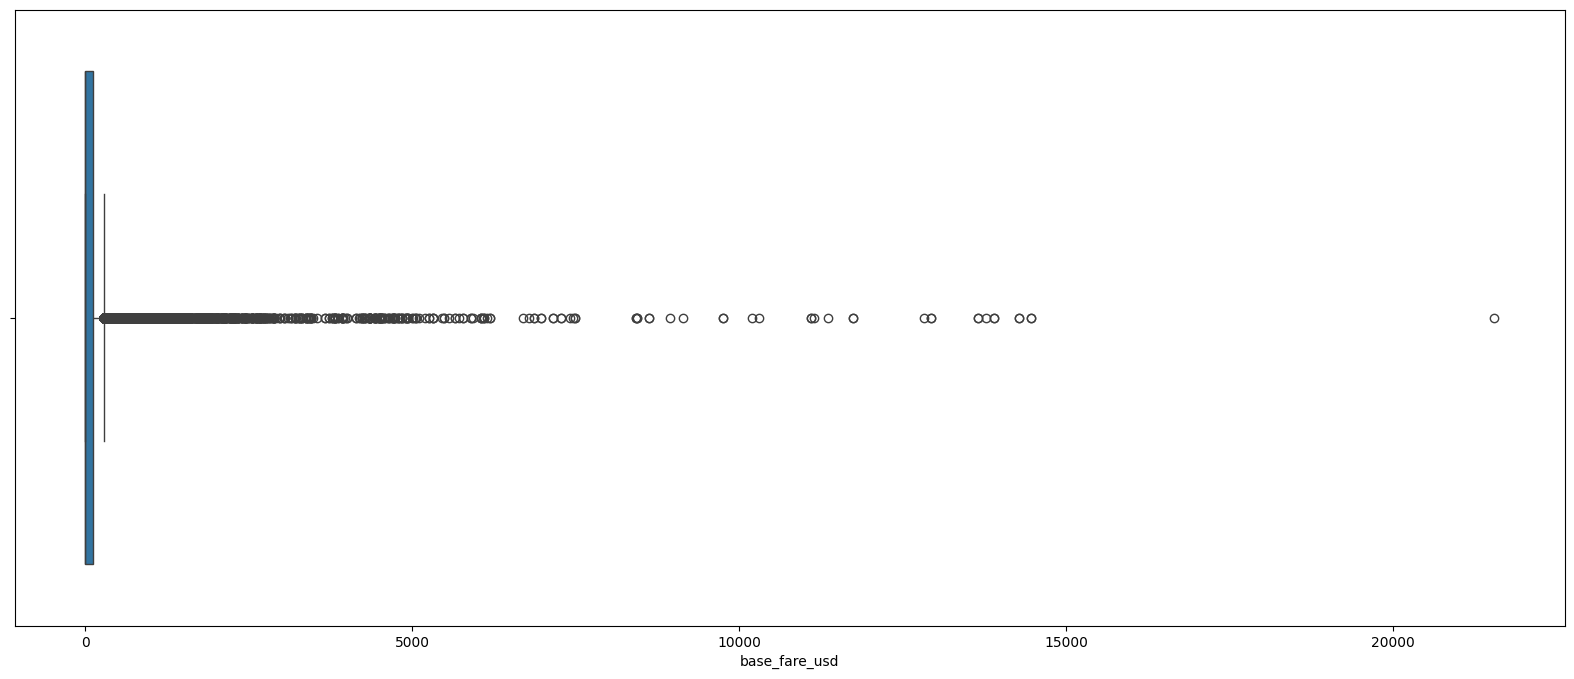

In [0]:
plt.figure(figsize=(20,8))
sns.boxplot(x=df.base_fare_usd)
plt.show()

In [0]:
df[df.session_cost == df.session_cost.max()]

,session_id,user_id,trip_id,session_start,session_end,page_clicks,flight_discount,flight_discount_amount,hotel_discount,hotel_discount_amount,flight_booked,hotel_booked,cancellation,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,age_bin,status,distance_km,duration,session_cost
43591,534594-846549e9777942e6b094db69109b0a32,534594,534594-13bf73d74306431d9fdd9318110426c8,2023-07-01 17:08:00,2023-07-01 17:09:19,11,False,NaN,False,NaN,False,True,False,1980-01-15,F,True,False,canada,windsor,YQG,42.276,-82.956,2023-01-16,None,None,None,NaN,None,NaT,NaT,NaN,None,NaN,NaN,0.0,Best Western - los angeles,27.0,3.0,2023-07-04 11:00:00,2023-07-31 11:00:00,342.0,43,1.316667,NaN,"[40, 50)",booked_and_travelled,NaN,27.0,27702.0


# Days between session and travel

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration', 'session_cost'],
      dtype='object')

In [0]:
def from_session_to_travel(row):
    if row['status'] != 'booked_and_travelled':
        return np.nan
    
    if pd.notnull(row['departure_time']):
        return ((row['departure_time'] - row['session_end']).total_seconds() / (60*60*24))
    
    elif pd.notnull(row['check_in_time']):
        return ((row['check_in_time'] - row['session_end']).total_seconds() / (60*60*24))
    
    else:
        return np.nan

In [0]:
df['booking_window_days'] = df.apply(lambda row: from_session_to_travel(row), axis=1)

In [0]:
df[df.status == 'booked_and_travelled']['booking_window_days'].isnull().sum()

np.int64(0)

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration', 'session_cost', 'booking_window_days'],
      dtype='object')

#Family sessions or not

In [0]:
a = df[(df.has_children) & (df.status == 'booked_and_travelled')]
a.shape

(4691, 50)

In [0]:
a[(a.seats.notnull()) | (a.rooms.notnull())].shape
# when has_children is true and status = booked_and_travelled, there is either seats or rooms not null

(4691, 50)

In [0]:
b = df[(df.status == 'booked_and_travelled') & (df.seats == 2) & (df.rooms == 1)]
b.shape
#I was trying to search for couples travelling, but those with 2 seats and 1 rooms are only 41, so makes no sense to create this segment

(41, 50)

In [0]:
def family_session(row):
    if row.has_children:   # it's a family session only if the user has children
        if row['seats'] > 1:
            return True
        elif pd.isnull(row['seats']) and row['rooms'] > 1:
            return True
        else:
            return False
    else:
        return False    

In [0]:
df['family_session'] = df.apply(lambda row: family_session(row), axis=1)

In [0]:
df[df.status == 'booked_and_travelled']['family_session'].value_counts()

family_session
False    14596
True       770
Name: count, dtype: int64

#Save Dataframe to Delta Lake Tab

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration', 'session_cost', 'booking_window_days',
       'family_session'],
      dtype='object')

In [0]:
%sql
/* to drop the delta lake table, before recreating it*/
DROP TABLE workspace.default.df_sessions_tab;

In [0]:
#better to first drop the table, then create it again

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Save as Delta Lake table
spark_df.write.format("delta").mode("overwrite").saveAsTable("df_sessions_tab")